# **4. ML - Classification**

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np

# Cargar el archivo CSV
df = pd.read_csv('../data/processed/campana_marketing.csv', parse_dates=['Dt_Customer'])

# Convertir la columna 'Income' de float64 a int64
df['Income'] = df['Income'].astype('int64')

## Nuestra variable objetivo será `AcceptedCmp`: 0 no se ha aceptado ninguna campaña y 1 se ha aceptado al menos 1 de las 5 campañas

In [43]:
# 1. Correlación con el Target
correlation_matrix = df.corr(numeric_only=True)
correlation_with_target = correlation_matrix['AcceptedCmp'].sort_values(ascending=False)
correlation_with_target

AcceptedCmp            1.000000
AcceptedCmp4           0.553782
AcceptedCmp3           0.551957
AcceptedCmp5           0.548292
AcceptedCmp1           0.510624
MntWines               0.465034
Spent                  0.412466
Response               0.367401
Income                 0.315024
NumCatalogPurchases    0.313291
MntMeatProducts        0.274626
AcceptedCmp2           0.229464
NumWebPurchases        0.213228
MntGoldProds           0.190782
NumStorePurchases      0.186765
MntFishProducts        0.160046
MntSweetProducts       0.159584
MntFruits              0.126553
Education              0.047823
Age                    0.030778
Marital_Status        -0.000198
Days                  -0.013751
Seniority             -0.013751
Recency               -0.017745
Complain              -0.027016
Year_Birth            -0.030778
ID                    -0.041206
NumDealsPurchases     -0.086570
Teenhome              -0.099415
NumWebVisitsMonth     -0.125986
Kidhome               -0.203024
Child_Ho

## Selección de variables X e Y

1. Determinamos que las variables con una correlación entre 0.2 y -0.2 quedarán excluidas de nuestro entrenamiento, ya que se encuentran entorno al 0 y parecen que no afectan a la variable objetivo y así aligeramos el proceso de entrenamiento.
2. Usando una **list comprehension** eliminamos las características `AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4 y AcceptedCmp5`, ya que son subproducto de AcceptedCmp.

In [44]:
# Filtrar correlaciones fuera del rango [-0.2, 0.2]
filtered_correlations = correlation_with_target[
    correlation_with_target.abs() > 0.2
].sort_values(ascending=False)

# Lista final de features, excluyendo las variables derivadas de 'AcceptedCmp'
excluded_features = ['AcceptedCmp', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
features = [f for f in filtered_correlations.index if f not in excluded_features]

print("Características seleccionadas:", features)

Características seleccionadas: ['MntWines', 'Spent', 'Response', 'Income', 'NumCatalogPurchases', 'MntMeatProducts', 'NumWebPurchases', 'Kidhome', 'Child_Home']


Definimos las variables

In [45]:
X = df[features]
y = df['AcceptedCmp']

## División de datos
Cogeremos el 20% para test y el 80% para training

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tratamiento del Desbalance de Clases
Como vimos en [**EDA**](04_explore_data.ipynb), al final del análisis no gráfico, `AcceptedCmp` tiene la clase está desbalanceada.
En este escenario, la clase minoritaria (en nuestro caso, la clase 1) está significativamente menos representada que la clase mayoritaria (la clase 0). Esto puede generar varios problemas al entrenar un modelo de clasificación.

### Rebalancear clases
Optamos por hacer un Submuestreo (**Undersampling**), reduciendo el número de ejemplos de la clase mayoritaria.

Dada la significativa disparidad en la representación de las clases en nuestro conjunto de datos, con una marcada predominancia de la clase mayoritaria (clase 0), se ha optado por aplicar la técnica de submuestreo (undersampling). El objetivo principal de esta estrategia es reducir el número de instancias de la clase mayoritaria para mitigar el sesgo del modelo hacia esta clase y mejorar su capacidad para aprender y predecir la clase minoritaria (clase 1) de manera más efectiva.

In [47]:
# Aplicar undersampling para balancear las clases
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

## Estandarización con `StandardScaler`
1. Se estandarizan los datos para el entrenamiento de modelos de **Regresión Logística** y **SVM** porque son sensibles a la escala de las características, lo que puede afectar su convergencia y rendimiento. 
2. Para **KNN** y **Random Forest**, la estandarización no es estrictamente necesaria debido a su funcionamiento basado en distancias relativas o divisiones de características individuales, y para **Redes Neuronales**, la decisión se toma considerando el contexto específico del experimento.

In [48]:
# Aplicamos StandardScaler solo a los datos originales (sin rebalanceo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Selección de modelos
Para el **Desbalance de Clases**, ajustamos pesos en el modelo (más fácil y eficiente) con `class_weight='balanced`. 

Como los modelos **KNN** y **Neural Network** no son compatibles para que se ajusten, aquí sí que aplicaremos el undersampling `X_resampled, y_resample` que se ha hecho previamente.

Los datos ya estandarizados `X_train_scaled`se usarán solo para entrenar en los modelos **Logistic Regression** y **SVM**.

In [49]:
# Modelos con ajuste de pesos para modelos compatibles
models = {
    'Logistic Regression': (LogisticRegression(max_iter=2000, class_weight='balanced'), X_train_scaled, y_train),
    'KNN': (KNeighborsClassifier(), X_resampled, y_resampled),
    'Random Forest': (RandomForestClassifier(class_weight='balanced'), X_train, y_train),
    'SVM': (SVC(probability=True, class_weight='balanced'), X_train_scaled, y_train),
    'Neural Network': (MLPClassifier(), X_resampled, y_resampled)
}

## Hiperparámetros para la Búsqueda Exhaustiva con GridSearchCV

In [50]:
# Hiperparámetros para GridSearchCV
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [3, 5, 10]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
    'Neural Network': {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01, 0.05],
        'learning_rate': ['constant','adaptive']
    }
}

## Entrenamiento

In [51]:
results = {}
best_models = {}

for model_name, (model, X_data, y_data) in models.items():
    print(f"\nEntrenando {model_name}...")

    grid_search = GridSearchCV(model, param_grid[model_name], scoring='roc_auc', n_jobs=-1, cv=5)
    grid_search.fit(X_data, y_data)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Usar X_test_scaled solo en modelos que lo requieren
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    y_pred = best_model.predict(X_test_final)

    # Verificar si el modelo tiene 'predict_proba'
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
    else:
        y_pred_proba = np.zeros_like(y_pred)  # En caso de que el modelo no tenga predict_proba

    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Best Params': best_params
    }
    best_models[model_name] = best_model

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results).T
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']] = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].astype(float)


Entrenando Logistic Regression...

Entrenando KNN...

Entrenando Random Forest...

Entrenando SVM...

Entrenando Neural Network...


## Resultados

In [52]:
print("\nResultados de los modelos:")
print(results_df)

# Determinar el mejor modelo basado en diferentes métricas
best_metrics = {metric: results_df[metric].idxmax() for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']}

print("\n🔹 Mejores modelos por métrica:")
for metric, model in best_metrics.items():
    print(f"Mejor modelo basado en {metric}: {model} - {results_df.at[model, 'Best Params']}")


Resultados de los modelos:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Logistic Regression  0.783296   0.516340  0.782178  0.622047  0.830844   
KNN                  0.697517   0.400000  0.653465  0.496241  0.742212   
Random Forest        0.835214   0.659091  0.574257  0.613757  0.866887   
SVM                  0.792325   0.530201  0.782178  0.632000  0.847577   
Neural Network       0.758465   0.000000  0.000000  0.000000  0.567280   

                                                           Best Params  
Logistic Regression                                           {'C': 1}  
KNN                                                {'n_neighbors': 11}  
Random Forest        {'max_depth': 10, 'max_features': 'sqrt', 'n_e...  
SVM                                           {'C': 10, 'gamma': 0.01}  
Neural Network       {'activation': 'relu', 'alpha': 0.0001, 'hidde...  

🔹 Mejores modelos por métrica:
Mejor modelo basado en Accuracy: Random Forest - {'max_de

## Análisis de los Resultados

**Interpretación Detallada:**

* **Random Forest: El Modelo con Mejor Rendimiento General**
    * Obtiene la **mayor precisión global (Accuracy: 83.5%)** y la **mejor capacidad para identificar correctamente la clase positiva (Precision: 65.9%)**.
    * También demuestra la **mejor capacidad para distinguir entre las clases positiva y negativa (ROC AUC: 86.7%)**.
    * Estos resultados sugieren que Random Forest es el modelo más robusto para este problema en términos de rendimiento general.

* **Logistic Regression y SVM: Fortalezas en la Identificación de Positivos (Recall)**
    * Ambos modelos muestran un **alto Recall (aproximadamente 78.2%)**, lo que indica que son efectivos para capturar la mayoría de las instancias de la clase positiva.
    * Sin embargo, **SVM presenta un F1 Score superior (0.632 vs. 0.622)** en comparación con la Regresión Logística, lo que sugiere un mejor equilibrio entre la precisión y la exhaustividad en sus predicciones.

* **KNN: Rendimiento Subóptimo**
    * KNN muestra una **precisión baja (40.0%)** y un **área bajo la curva ROC modesta (74.2%)**, lo que sugiere que no está generalizando bien a los datos de prueba y tiene dificultades para predecir la clase positiva sin generar muchos falsos positivos.

* **Neural Network: Fallo en el Aprendizaje**
    * El modelo de Red Neuronal presenta **métricas de Precision, Recall y F1 Score en cero**, junto con un ROC AUC cercano a 0.5. Esto indica que el modelo no ha logrado aprender patrones útiles de los datos y está realizando predicciones esencialmente aleatorias para la clase positiva.

**Conclusiones y Próximos Pasos:**

* **Random Forest se identifica como el modelo más prometedor** debido a su rendimiento superior en Accuracy, Precision y ROC AUC.
* **SVM podría ser una alternativa valiosa** si el objetivo principal es maximizar la identificación de casos positivos (alto Recall), manteniendo un equilibrio razonable con la precisión.
* **El rendimiento deficiente de la Red Neuronal requiere atención.** Aunque es el modelo con mayor complejidad computacional y no se priorizará su mejora en este momento, este resultado sugiere posibles problemas con la configuración de la red (arquitectura, hiperparámetros) o la necesidad de un preprocesamiento más exhaustivo de los datos en futuros experimentos.
* **El rendimiento de KNN también es bajo**, lo que indica que la relación entre las características y la variable objetivo podría no ser bien capturada por la proximidad de los vecinos en el espacio de características.

## Visualización de los Resultados

### Matriz de Confusión

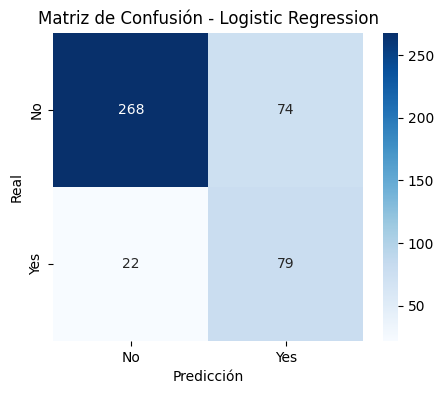

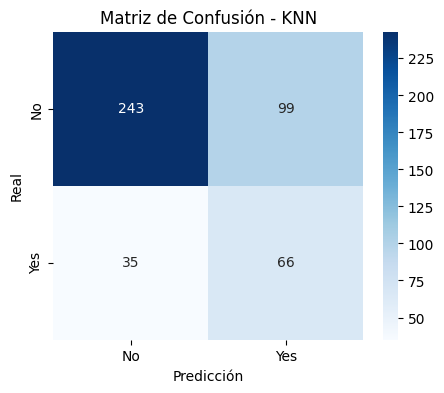

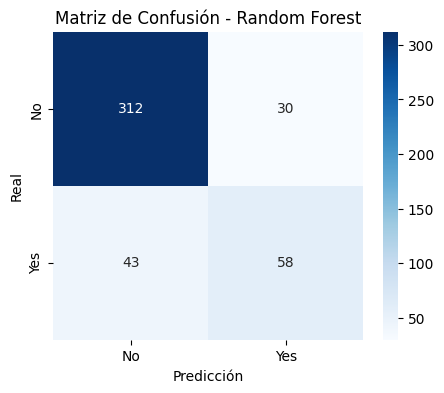

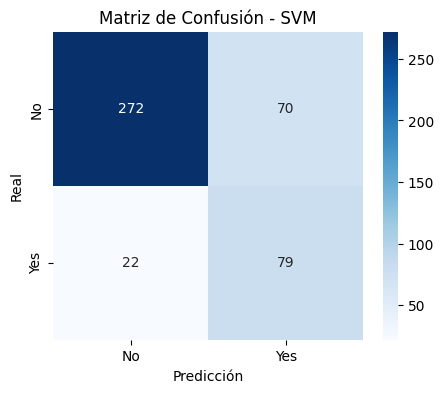

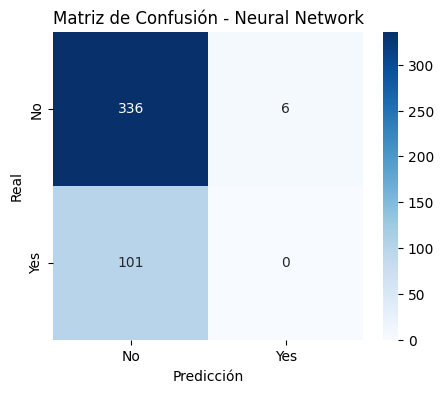

In [54]:
def plot_confusion_matrix(model_name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

# Visualizar para los mejores modelos
for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test
    y_pred = best_model.predict(X_test_final)
    plot_confusion_matrix(model_name, y_test, y_pred)

### Curva ROC

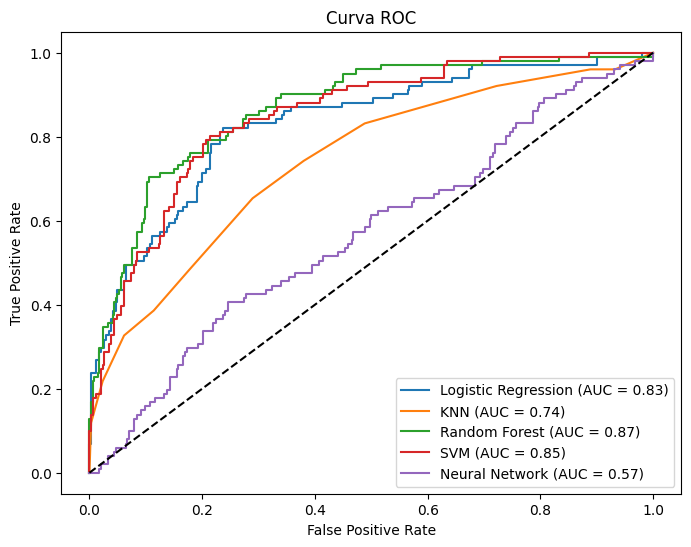

In [56]:
plt.figure(figsize=(8, 6))

for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    if hasattr(best_model, "predict_proba"):  # Verificar si tiene predict_proba
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
    else:
        continue  # Si el modelo no tiene predict_proba, lo ignoramos

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (modelo aleatorio)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()